# Introduction

This week, we are going to replicate the result published on the arXiv 1805.00794 (<a href ="https://arxiv.org/pdf/1805.00794.pdf"> link </a>). They provides on Kaggle both datasets already prepared so nearly only the model has to be trained.

Let's start by loading data !

# Loading data

In [1]:
import math
import random
import pickle
import itertools

from keras.models import load_model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [38]:
df = pd.read_csv("F:/data/heartbeat/mitbih_train.csv", header=None)
df2 = pd.read_csv("F:/data/heartbeat/mitbih_test.csv", header=None)

In [39]:
df = pd.concat([df, df2], axis=0)

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


So me know that the first 187 features are time-padded heartbeat and the last column is the class. We can check the dataset balance.

In [42]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

The dataset is quite unbalanced which is quite logical as we have less people sick than healthy. The most complex one remain the 4th category which is very low. We will try to augment it afterward

In [43]:
M = df.as_matrix()

In [44]:
X = M[:, :-1]
y = M[:, -1].astype(int)

In [45]:
del df
del df2
del M

In [46]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

Let's plot a beat for every kind of heartbeat :

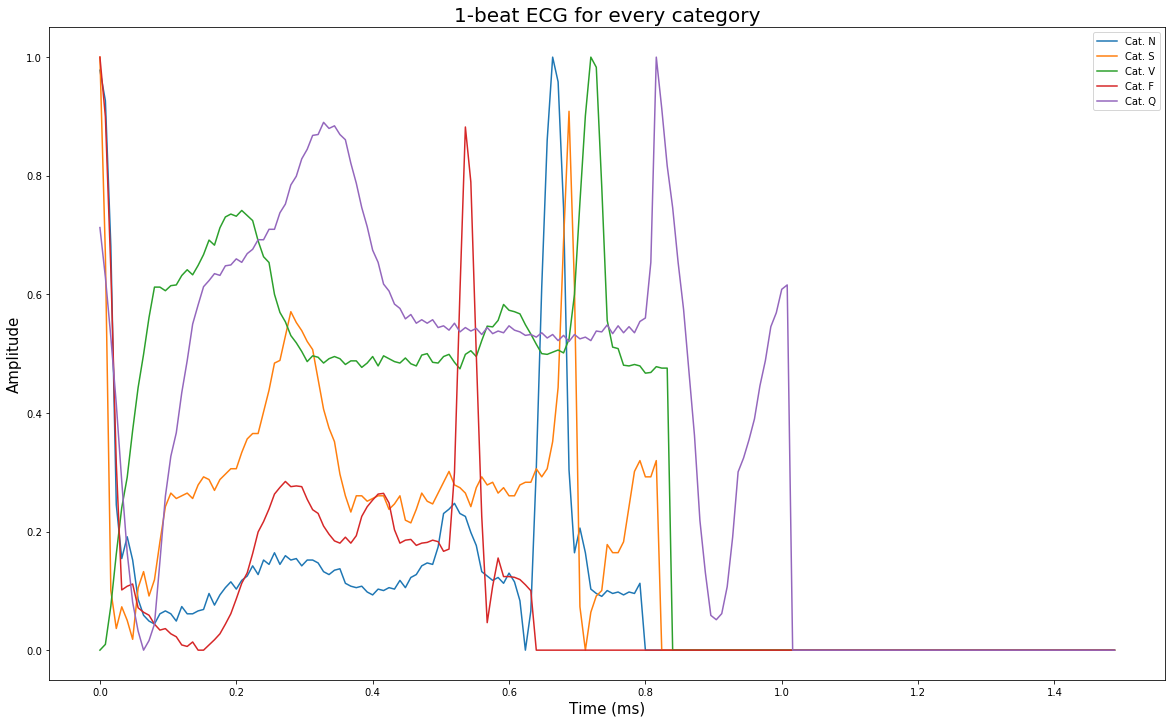

In [47]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

I'm not doctor so I won't comment it a lot but we can see that the category the risk is mainly related to the height of the middle area. The higher it is, the less amplitude the hearth have so the more risks there is "I guess"

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations. For the augmentation, we will stretch the signal in time and in amplitude too. For amplitude, the factor will depend on the current amplitude of the signal to keep the max at 1. As we saw previously, we should also not amplify it a lot to not change the category.

For the time, a small stretching factor is apply and signal is re-padded to 187 steps

In [48]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

In [49]:
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

In [50]:
def test(x):
    result = np.zeros(shape= (3, 187))
    for i in range(3):   # we need to multiply each input by around 4 to reach a correct amount
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

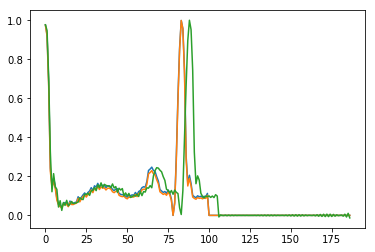

In [51]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [52]:
result = np.apply_along_axis(test, axis=1, arr=X[C3]).reshape(-1, 187)

In [53]:
classe = np.ones(shape=(result.shape[0],), dtype=int)*3

Now let's add those augmented datas to the dataset

In [ ]:
X = np.vstack([X, result])
y = np.hstack([y, classe])

# Split

As our dataset is unbalanced, we will use only a subset of same quantity of each class. This will be more accurate.

In [55]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [56]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

In [57]:
X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

In [58]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [59]:
del X
del y

In [60]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [61]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109147, 187, 1)
y_train (109147,)
X_test (4000, 187, 1)
y_test (4000,)


In [62]:
np.save("F:/data/heartbeat/X_train.npy", X_train)
np.save("F:/data/heartbeat/y_train.npy", y_train)
np.save("F:/data/heartbeat/X_test.npy", X_test)
np.save("F:/data/heartbeat/y_test.npy", y_test)

# Model

In [15]:
import numpy as np
import pickle
import math
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [18]:
X_train = np.load("F:/data/heartbeat/X_train.npy")
y_train = np.load("F:/data/heartbeat/y_train.npy")
X_test = np.load("F:/data/heartbeat/X_test.npy")
y_test = np.load("F:/data/heartbeat/y_test.npy")

In [21]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [4]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109147, 187, 1)
y_train (109147, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


In [5]:
n_obs, feature, depth = X_train.shape
batch_size = 500

The model is explained in part III A of the document

In [6]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

Based also on their document:
    
<i> Learning rate is decayed exponentially with the
decay factor of 0.75 every 10000 iterations </i>

In [7]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

Based also on their document:
    
<i> For training
the networks, we used Adam optimization method [22] with
the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999,
respectively </i>

In [8]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

This is from me to save the best model

In [9]:
ckpt = ModelCheckpoint("model", 
                       monitor='val_loss', 
                       verbose=0, 
                       save_best_only=False, 
                       save_weights_only=False, 
                       mode='min', 
                       period=1)

Based also on their document:
    
<i> Cross entropy loss on
the softmax outputs is used as the loss function</i>

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate, ckpt])

Train on 109147 samples, validate on 4000 samples
Epoch 1/150
 - 6s - loss: 0.3812 - acc: 0.8870 - val_loss: 0.8361 - val_acc: 0.7680
Epoch 2/150
 - 4s - loss: 0.1322 - acc: 0.9641 - val_loss: 0.6263 - val_acc: 0.8320
Epoch 3/150
 - 4s - loss: 0.0944 - acc: 0.9738 - val_loss: 0.5435 - val_acc: 0.8308
Epoch 4/150
 - 4s - loss: 0.0780 - acc: 0.9780 - val_loss: 0.4927 - val_acc: 0.8637
Epoch 5/150
 - 4s - loss: 0.0694 - acc: 0.9806 - val_loss: 0.3962 - val_acc: 0.8758
Epoch 6/150
 - 4s - loss: 0.0602 - acc: 0.9824 - val_loss: 0.3434 - val_acc: 0.8910
Epoch 7/150
 - 4s - loss: 0.0528 - acc: 0.9845 - val_loss: 0.4123 - val_acc: 0.8712
Epoch 8/150
 - 4s - loss: 0.0488 - acc: 0.9853 - val_loss: 0.3270 - val_acc: 0.8955
Epoch 9/150
 - 4s - loss: 0.0464 - acc: 0.9862 - val_loss: 0.4620 - val_acc: 0.8725
Epoch 10/150
 - 4s - loss: 0.0430 - acc: 0.9873 - val_loss: 0.2814 - val_acc: 0.9088
Epoch 11/150
 - 4s - loss: 0.0406 - acc: 0.9875 - val_loss: 0.3313 - val_acc: 0.9015
Epoch 12/150
 - 4s - los

Epoch 97/150
 - 4s - loss: 0.0066 - acc: 0.9976 - val_loss: 0.3263 - val_acc: 0.9425
Epoch 98/150
 - 4s - loss: 0.0058 - acc: 0.9979 - val_loss: 0.2820 - val_acc: 0.9505
Epoch 99/150
 - 4s - loss: 0.0069 - acc: 0.9975 - val_loss: 0.2997 - val_acc: 0.9407
Epoch 100/150
 - 4s - loss: 0.0063 - acc: 0.9978 - val_loss: 0.3760 - val_acc: 0.9457
Epoch 101/150
 - 4s - loss: 0.0071 - acc: 0.9975 - val_loss: 0.3127 - val_acc: 0.9437
Epoch 102/150
 - 4s - loss: 0.0082 - acc: 0.9972 - val_loss: 0.2972 - val_acc: 0.9395
Epoch 103/150
 - 4s - loss: 0.0069 - acc: 0.9975 - val_loss: 0.3728 - val_acc: 0.9312
Epoch 104/150
 - 4s - loss: 0.0068 - acc: 0.9976 - val_loss: 0.3095 - val_acc: 0.9420
Epoch 105/150
 - 4s - loss: 0.0061 - acc: 0.9980 - val_loss: 0.2703 - val_acc: 0.9490
Epoch 106/150
 - 4s - loss: 0.0039 - acc: 0.9985 - val_loss: 0.4268 - val_acc: 0.9322
Epoch 107/150
 - 4s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.2772 - val_acc: 0.9445
Epoch 108/150
 - 4s - loss: 0.0044 - acc: 0.9985 - val_lo

In [12]:
with open("result_full.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Result Training

Now we trained the model on lot less epoch that what they did because we have quickly overfitting. This is visible by the trend of the test loss. I don't know why they don't had it on their test. In my case, i needed 4s/Epoch on a GTX1070 and they let it ran for 2+hours on a GTX1080 Ti so more than 2k Epochs

In [3]:
with open("result_full.pkl", "rb") as f:
    history = pickle.load(f)

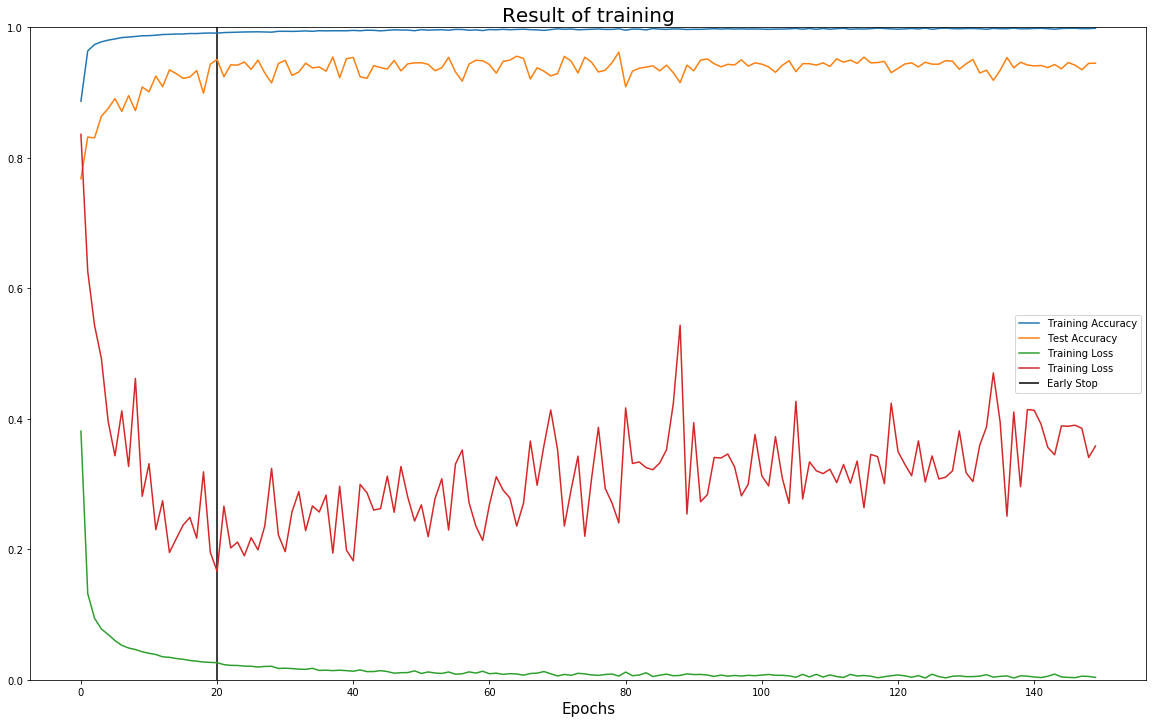

In [15]:
plt.figure(figsize=(20,12))
plt.plot(history["acc"], label = "Training Accuracy")
plt.plot(history["val_acc"], label = "Test Accuracy")
plt.plot(history["loss"], label = "Training Loss")
plt.plot(history["val_loss"], label = "Training Loss")
plt.vlines(20, 0, 1, label = "Early Stop")
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epochs", fontsize = 15)
plt.title("Result of training", fontsize= 20)
plt.show()

# Evaluation

Now let's look at result but still with a critic eye as we still use the test set which was used for the early stop...

In [16]:
model = load_model("model")

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
y_pred = model.predict(X_test, batch_size=1000)

In [24]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91       800
          1       0.99      0.85      0.92       800
          2       0.94      0.97      0.96       800
          3       0.99      0.92      0.95       800
          4       1.00      0.99      0.99       800

avg / total       0.95      0.95      0.95      4000



In [40]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision : 0.971
Ranking loss : 0.017
Coverage_error : 1.068


Confusion matrix, without normalization


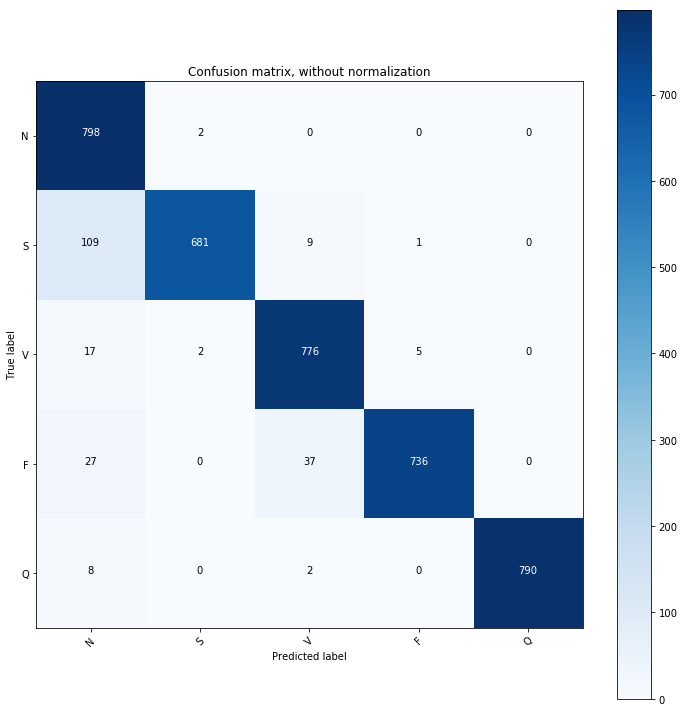

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()

The accuracy is close to the one from the paper but we have a lot more confusion between category N and S (12% vs 8%) for them.

# Unsupervised learning on learned features

They also used their model as feature extractor with after a TSNE optimisation to visualize it. We can do the same but to avoid overfitting, use the second dataset (even if we don't have the same class)

In [7]:
df = pd.read_csv("F:/data/heartbeat/ptbdb_normal.csv", header=None)
df2 = pd.read_csv("F:/data/heartbeat/ptbdb_abnormal.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [12]:
model = load_model("model")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14552 entries, 0 to 10505
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 21.0 MB


In [9]:
M = df.as_matrix()
X = M[:, :-1]
y = M[:, -1].astype(int)

X = np.expand_dims(X, 2)

In [10]:
del df
del M

In [16]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("flatten_1").output)

In [19]:
y_latent = intermediate_layer_model.predict(X, batch_size=150)
y_label = model.predict(X, batch_size=150)

In [22]:
np.save("F:/data/heartbeat/ylatent.npy", y_latent)
np.save("F:/data/heartbeat/y_label.npy", np.argmax(y_label, axis=1))

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y_embedded = tsne.fit_transform(y_latent)

If we plot the result of TSNE on the second dataset with predicted classes of the model initial. We can see that we nearly only find heartbeat without issues even if there is several ones

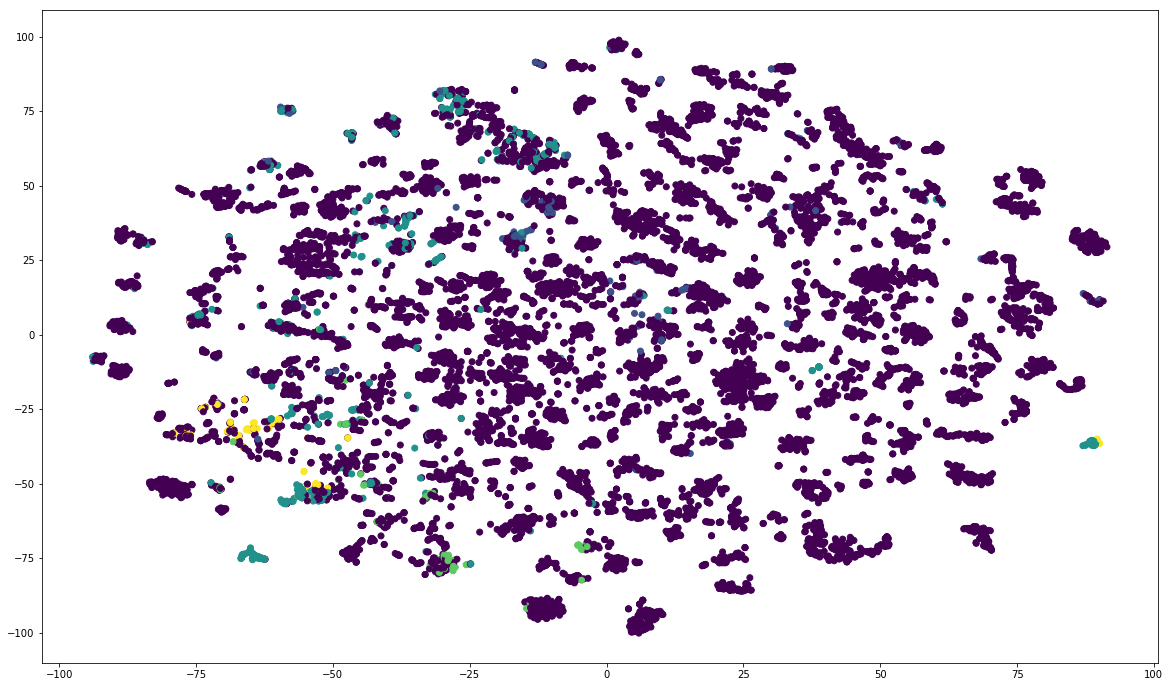

In [28]:
plt.figure(figsize=(20, 12))
plt.scatter(y_embedded[:, 0], y_embedded[:, 1], c=np.argmax(y_label, axis=1))
plt.show()

If we now uses classes from the dataset (Binary class), we can see that we are able to detect clusters of heartbeat with issues or not but they are not similar. Mainly we can say that the TSEN is able to detect heartbeat per person where it comes from but that's all. Every clusters are with heartbeat from the same user (science alreayd shows that everybody has a specific heartbeat signal and it's sometimes used as cryptography key)

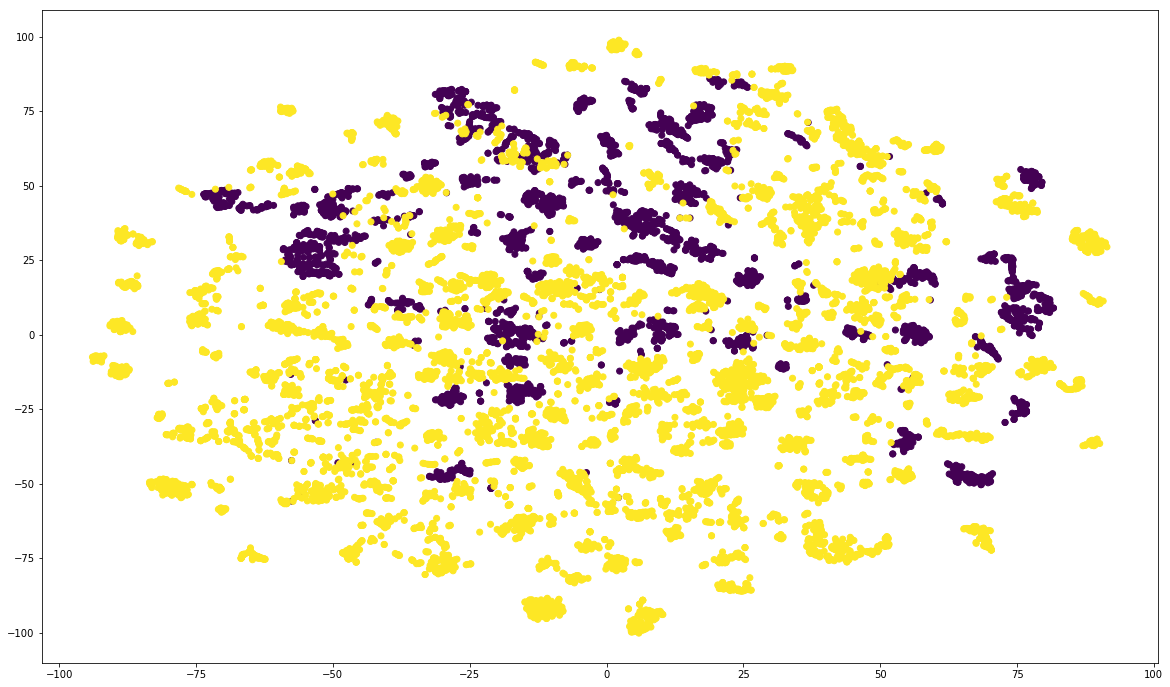

In [29]:
plt.figure(figsize=(20, 12))
plt.scatter(y_embedded[:, 0], y_embedded[:, 1], c=y)
plt.show()

# Conclusion

After re-creating the model from the paper and train it, we can see that it suffers of overfitting. It is perfecty good to detect problem but only for specific persons and is not as accuracte when it has complete new datas from another user. This is a bias of the dataset as we split heartbeats from 500 persons to multiple heartbeat unique. As a result the model have overfitting more easily. This is visible with the second dataset with the same pre-processing. 

Nevertheless, we discovered the principle of classify temporal datas with 1D convolutionnal Layer which is interesting compare to RNN.

# Bonus

In [47]:
import numpy as np
import pandas as pd

In [63]:
X_train = np.load("F:/data/heartbeat/X_train.npy")
y_train = np.load("F:/data/heartbeat/y_train.npy")
X_test = np.load("F:/data/heartbeat/X_test.npy")
y_test = np.load("F:/data/heartbeat/y_test.npy")

In [64]:
X_train = X_train.reshape(-1, 187)
X_test = X_test.reshape(-1, 187)

In [65]:
X_test.shape

(4000, 187)

In [66]:
def process(x):
    diff = np.diff(x, axis=1)
    diffd = np.diff(diff, axis=1)
    mean = x.sum(axis=1)
    mean_d = diff.sum(axis=1)
    mean_dd = diffd.sum(axis=1)

    temp = pd.DataFrame({
        "mean" : mean,
        "meand" : mean_d,
        "meandd" : mean_dd
    })

    return temp

X_train = process(X_train)
X_test = process(X_test)

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.829999908380441
0.2
